<a href="https://colab.research.google.com/github/LinarKulinar/BigDataLab1/blob/master/Lab0_Matmul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Высокопроизводительные вычисления.**

**Лабораторная 0. Сравнение времени перемножения матриц на CPU и GPU.**

Самарский университет

В данном блокноте реализован алгоритм перемножения матриц на языке python для CPU и для GPU.

Для перемножения матриц на GPU используется библиотека PyCuda.

Данный код запущен в среде Google Colaboratory

In [1]:
! pip install pycuda

     |████████████████████████████████| 1.7 MB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 66 kB 5.3 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626633 sha256=ac15d59996498bf020f963e9cd4d70ee4841fb0496f11ca8acbe9f8a706a0c4f
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=67a625c8820177c199174011b05c58e0fee9b01f124ff25634328f61ea5bff6d
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


In [2]:
!nvidia-smi

Sat Jan  8 01:26:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [4]:
import numpy as np
np.random.seed(0) 

import pycuda.autoinit
from pycuda import driver, gpuarray
from pycuda.compiler import SourceModule
import time

In [45]:
# multiplication functions

## GPU
mod = SourceModule("""
        __global__ void mult_gpu(double* A, double* B, double* C){
                const int row =  threadIdx.y + blockIdx.y * blockDim.y;
                const int column = threadIdx.x + blockIdx.x * blockDim.x;
                const int N = 1024;
                for(int i = 0; i < N; i++){
                        C[column + row * N] += A[i + row * N] * B[column + i * N];              
                }       
        }
""")

## simple CPU function
def mult_cpu(A, B):
    C, n  = np.zeros((N, N)), range(N)
    for i in n:
        for j in n:
            for k in n:
                C[i, j] += A[i, k] * B[k, j]
    return C

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

  del sys.path[0]


In [46]:
sizes = [128, 256, 512, 1024, 2048]
N = sizes[3] # matrix size

# matrix
A, B, C_gpu= np.random.randn(N, N).astype(np.float), np.random.randn(N, N).astype(np.float), np.ones((N, N)).astype(np.float)

In [47]:
# GPU multiplication

## GPU preparing
block_size = [2, 2]
block, grid = (block_size[0], block_size[1], 1), (int((N + block_size[0] - 1) / 2), int((N + block_size[1] - 1) / 2))
mult = mod.get_function("mult_gpu")


## GPU multiplication
start_gpu = time.time()
mult(driver.In(A), driver.In(B), driver.Out(C_gpu), block = block, grid = grid)
driver.Context.synchronize()
time_gpu = time.time() - start_gpu

In [ ]:
# CPU multiplication 
start_cpu = time.time()
C_cpu = mult_cpu(A, B)
time_cpu = time.time() - start_cpu

In [ ]:
# Compare results matrix
C_gpu-C_cpu<1e-10

In [ ]:
# results
print('CPU time: ', round(time_cpu, 4))
print('GPU time: ', round(time_gpu, 4))

print('Results converge;  acceleration: ', round(time_cpu/time_gpu, 4)) if np.allclose(C_gpu, C_cpu) else print('Results do not converge')

In [ ]:
# visualization results
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd


cpu_time = [1.932, 15.0544, 119.3973, 859.1499, 6723.3339]
gpu_time = [0.0057, 0.0129, 	0.108, 0.0493, 0.326]
acceleration = [338.5331, 1167.0078, 1105.3132, 17435.5929, 20621.3875]

result= pd.DataFrame({'cpu_time': cpu_time, 'gpu_time': gpu_time, 'acceleration': acceleration, 'size': sizes})
result = result.set_index('size')
result.head()

In [24]:
# # visualization results
# import seaborn as sns
# sns.set_theme(style="darkgrid")
# import pandas as pd


# cpu_time = [1.5594, 11.5251, 93.4048, 859.1499, 6723.3339]
# gpu_time = [0.0016, 0.0032, 	0.0113, 0.0493, 0.326]
# acceleration = [1.5594, 3599.9234, 8254.5239, 17435.5929, 20621.3875]

# result= pd.DataFrame({'cpu_time': cpu_time, 'gpu_time': gpu_time, 'acceleration': acceleration, 'size': sizes})
# result = result.set_index('size')
# result.head()

,cpu_time,gpu_time,acceleration
size,,,
128,1.5594,0.0016,1.5594
256,11.5251,0.0032,3599.9234
512,93.4048,0.0113,8254.5239
1024,859.1499,0.0493,17435.5929
2048,6723.3339,0.3260,20621.3875


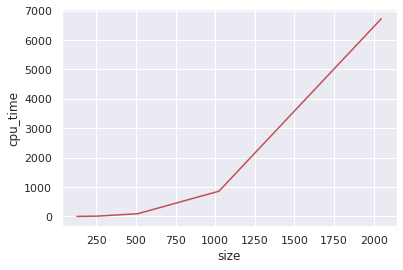

In [13]:
sns.lineplot(x="size", y="cpu_time", data=result, color='r')

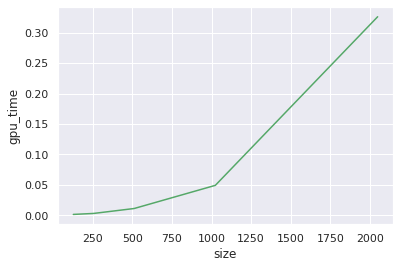

In [14]:
sns.lineplot(x="size", y="gpu_time", data=result, color='g')

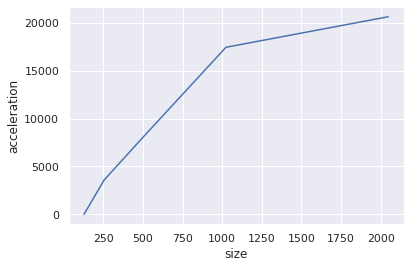

In [15]:
sns.lineplot(x="size", y="acceleration", data=result, color='b')